# Detection of defects in solar panel images.

## Importing packages

In [1]:
import os
import sys
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , accuracy_score

## Classes and functions

In [26]:
class InitializeClassPath():
    def __init__(self):
        root = str(sys.path[0])
        default_folder = (root + '\\Faulty_solar_panel\\')
        self.class_names = None
        self.folder_path = default_folder
        if os.path.exists(self.folder_path):
            self.class_names = pd.DataFrame(os.listdir(self.folder_path), columns = ['Class_names'])
            print('Default folder set.')
        else:
            print("Couldn't find default folder.")
            print("Default folder should be named Faulty_solar_panel. If you don't want to use default folder call 'SetFolder()'.")
        
    def SetFolder(self, folder_name = ''):
        root = str(sys.path[0])
        default_folder = (root + '\\Faulty_solar_panel\\')
        
        if folder_name == '':
            print('Default folder set.')
            self.folder_path = default_folder
            return
        
        self.folder_path = (root + folder_name)    
        
        if os.path.exists(self.folder_path):
            self.class_names = pd.DataFrame(os.listdir(self.folder_path), columns = ['Class_names'])
            print('Specified folder set.')
        else:
            print("Couldn't find specified folder.")
            print('Please use default folder or place folder with your classes in the same directory as script.')


class InitializeDatasetSettings():
    def __init__(self, batch_size = 32, target_size = (224, 224), validation_split = 0.2):
        if batch_size != 32 or target_size != (224, 224) or validation_split != 0.2:
            print('If you want to go back to default settings, remove your values when initializing class object.')
            
        self.batch_size = batch_size
        self.target_size = target_size
        self.validation_split = validation_split
        self.training = None
        self.validation = None

    def GetFiles(self, folder_path):
        self.training = tf.keras.preprocessing.image_dataset_from_directory(
            folder_path,
            validation_split=self.validation_split,
            subset="training",
            seed=100,
            image_size=self.target_size,
            batch_size=self.batch_size
        )

        self.validation = tf.keras.preprocessing.image_dataset_from_directory(
            folder_path,
            validation_split=self.validation_split,
            subset="validation",
            seed=200,
            image_size=self.target_size,
            batch_size=self.batch_size,
        )

def ShowSamples(dataset):
    plt.figure(figsize=(15, 20))
    for images, labels in dataset.training.take(1):
        for i in range(8):
            ax = plt.subplot(8, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(dataset.training.class_names[labels[i]])
            plt.axis("off")

class Model():
    def __init__(self, dataset):
        self.base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
        self.base_model.trainable = False
        self.keras_model = keras.models.Sequential(self.base_model)

        self.dataset = dataset
        self.checkpoint = None
        self.early_stopping = None

        self.hist = None

    def AddLayers(self, layers):
        if type(layers) != list:
            print('Wrong layer declaration!')
            return

        for layer in layers:
            self.keras_model.add(layer)
            print(f'Added {layer.name} layer succesfully!')

    def ShowSummary(self):
        self.keras_model.summary()

    
    def SetCheckpoint(self, name='model_checkpoint'):
        self.checkpoint = ModelCheckpoint((name+".keras"), save_best_only = True)

    def SetEarlyStopping(self, epochs=5):
        self.early_stopping = EarlyStopping(patience = epochs, restore_best_weights = True)

    
    def CompileAndRun(self, epo = 18, opt = 'rmsprop'):
        self.keras_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        
        if self.checkpoint != None and self.early_stopping != None:
            self.hist = self.keras_model.fit(
                self.dataset.training, 
                epochs = epo, 
                steps_per_epoch = len(self.dataset.training), 
                validation_data = self.dataset.validation, 
                callbacks = [self.checkpoint, self.early_stopping])
            
        elif self.checkpoint != None:
            self.hist = self.keras_model.fit(
                self.dataset.training, 
                epochs = epo, 
                steps_per_epoch = len(self.dataset.training), 
                validation_data = self.dataset.validation, 
                callbacks = self.checkpoint)
            
        elif self.early_stopping != None:
            self.hist = self.keras_model.fit(
                self.dataset.training, 
                epochs = epo, 
                steps_per_epoch = len(self.dataset.training), 
                validation_data = self.dataset.validation, 
                callbacks = self.early_stopping)
        else:
            self.hist = self.keras_model.fit(
                self.dataset.training, 
                epochs = epo, 
                steps_per_epoch = len(self.dataset.training), 
                validation_data = self.dataset.validation)
        
        
def ShowHistGraph(hist):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist_['loss'], label = 'Train Loss')
    plt.plot(hist_['val_loss'], label = 'Validation Loss')
    plt.title('Train Loss & Validation Loss', fontsize = 20)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist_['accuracy'], label = 'Train Accuracy')
    plt.plot(hist_['val_accuracy'], label = 'Validation Accuracy')
    plt.title('Train Accuracy & Validation Accuracy', fontsize = 20)
    plt.legend()

def ModelTest(dataset, model):
    X_val,y_val,y_pred=[],[],[]
    for images, labels in dataset.validation:
        y_val.extend(labels.numpy())
        X_val.extend(images.numpy())
    predictions=model.keras_model.predict(np.array(X_val))
    for i in predictions:
        y_pred.append(np.argmax(i))
    df=pd.DataFrame()
    df['Actual'],df['Prediction']=y_val,y_pred
    return df, {'X_val': X_val, 'y_val': y_val, 'y_pred': y_pred}

def ConfMatrix(metrics):
    ax= plt.subplot()
    CM = confusion_matrix(metrics['y_val'], metrics['y_pred'])
    sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    plt.show()

## Setting up images
### First setting path of our main folder with subfolders which are classes

In [3]:
# There are 6 different default class folders:
#
# Clean: This directory has images of clean solar panels
# Dusty: This directory has images of dusty solar panels
# Bird-drop: This directory has images of bird-drop on solar panels
# Electrical-damage: This directory has images of electrical-damage solar panels
# Physical-Damage: This directory has images of physical-damage solar panels
# Snow-Covered: This directory has images of snow-covered on solar panels
classes = InitializeClassPath()
print("")
print(classes.class_names)
print("")

dataset = InitializeDatasetSettings()
dataset.GetFiles(classes.folder_path)

Default folder set.

         Class_names
0          Bird-drop
1              Clean
2              Dusty
3  Electrical-damage
4    Physical-Damage
5       Snow-Covered

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


## Checking our data

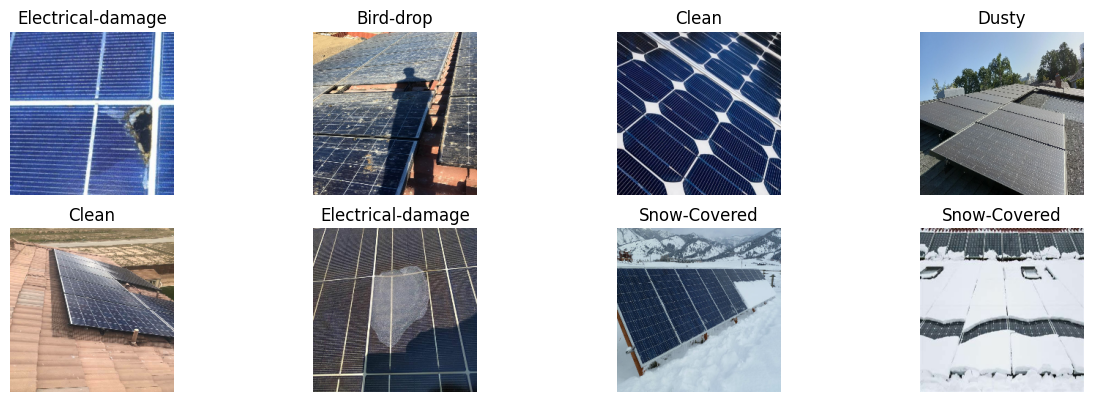

In [4]:
ShowSamples(dataset)

## Building and training the model

In [53]:
model = Model(dataset)

model.AddLayers([
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),

    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.PReLU(),


    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.PReLU(),

    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.PReLU(),



    keras.layers.BatchNormalization(),
    keras.layers.Dense(6, activation=tf.nn.softmax),
])

print('')

model.ShowSummary()

model.SetCheckpoint()
model.SetEarlyStopping()

model.CompileAndRun()

Added flatten_12 layer succesfully!
Added dropout_12 layer succesfully!
Added batch_normalization_48 layer succesfully!
Added dense_48 layer succesfully!
Added p_re_lu_36 layer succesfully!
Added batch_normalization_49 layer succesfully!
Added dense_49 layer succesfully!
Added p_re_lu_37 layer succesfully!
Added batch_normalization_50 layer succesfully!
Added dense_50 layer succesfully!
Added p_re_lu_38 layer succesfully!
Added batch_normalization_51 layer succesfully!
Added dense_51 layer succesfully!

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_12 (Flatten)        (None, 28224)             0         
                                                                 
 dropo

## Storing data of our run into variable

In [54]:
hist_ = pd.DataFrame(model.hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,1.530182,0.411017,1.940518,0.367232
1,0.821024,0.764124,1.151646,0.519774
2,0.559322,0.874294,0.692217,0.762712
3,0.408867,0.930791,0.488832,0.853107
4,0.289268,0.956215,0.325349,0.926554
5,0.220109,0.977401,0.242580,0.943503
6,0.195895,0.977401,0.215118,0.954802
7,0.134182,0.991525,0.185778,0.954802
8,0.110882,0.990113,0.156062,0.960452
9,0.101979,0.987288,0.154327,0.954802


## Checking history on graph to see if our model is overfitting

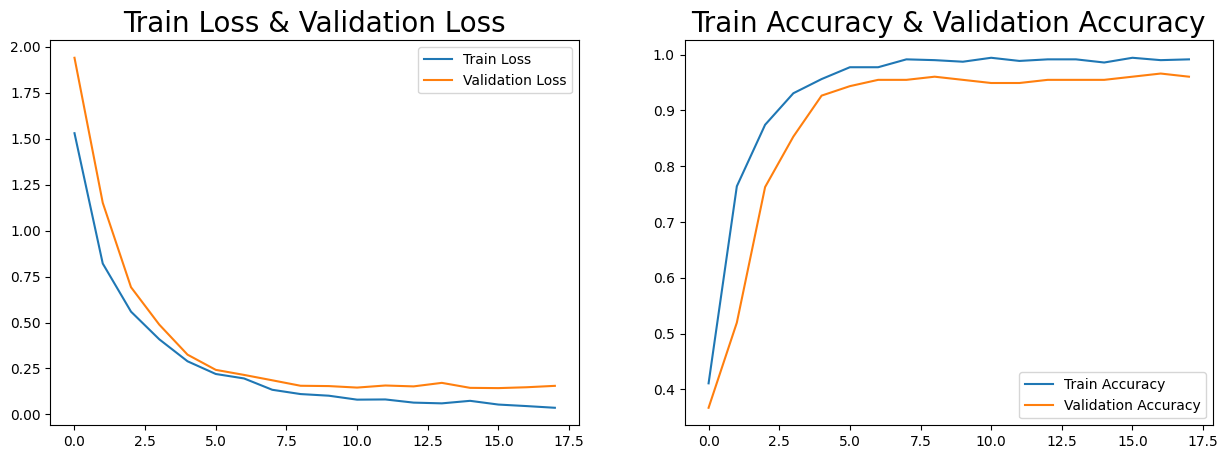

In [55]:
ShowHistGraph(hist_)

## Testing the model

In [56]:
df, metrics = ModelTest(dataset, model)
df

6/6 [==============================] - 1s 62ms/step


,Actual,Prediction
0,5,5
1,1,4
2,1,1
3,1,1
4,5,5
...,...,...
172,3,3
173,0,0
174,1,1
175,0,0


## Checking where model is mispredicting

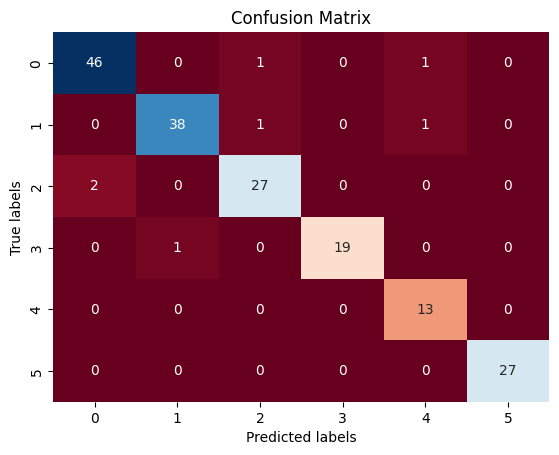

In [57]:
ConfMatrix(metrics)

## Calculating accuracy of our model

In [58]:
Acc = accuracy_score(metrics['y_val'], metrics['y_pred'])
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 96.045%
